# Simulating a Scalable Last Mile Delivery Service in the IDS Lab's Scaled Smart City

**Goal**: Simulates a last mile delivery service by using a directed graph representing the Scaled Smart City's road network and creating an algorithm to plan efficient delivery routes for up to 12 vehicles delivering up to 12 packages. The path planning algorithm must be scalable, and the final simulations will be outputted and validated in the physical scaled testbed. The algorithm will also incorporate a variable, alpha, to represent a particular company's structure in relation to the importance of minimizing operating cost (reducing vehicle travel time, α=0) versus the importance of maximizing customer satisfaction (reducing delivery times, α=1),

**Approach**: In each simulation, we randomly generate locations of packages by selecting nodes in the city's directed graph (excluding node 46, the depot, which we selected due to its central location). We then model paths for each possible number of vehicles, from 1 to the number of packages.

To maintain a reasonable computational cost as the number of packages increases, we divide our path planning algorithm into two parts. First, the packages are grouped into proximity-based clusters equal to the number of vehicles. The packages in each cluster is assigned to one vehicle. Second, the path for each vehicle is determined using a greedy search, where we compute the distances to all a vehicle's assigned packages, choose the closest, and repeat until all packages have been delivered.

Finally, we use an algorithm incorporating alpha to determine the optimal number of vehicles that should be used to jointly reduce total travel time and package delivery times.

See part 1 of this project, creating a directed graph to represent the Scaled Smart City, [here](https://colab.research.google.com/drive/1p-zjlDo3SOpL5MJNzk6E3QO0P3GKiLjr?usp=sharing).

The paper's website is available [here](https://sites.google.com/view/ud-ids-lab/lmds).

#Setup

In [ ]:
# starting files accessible here: https://drive.google.com/drive/folders/1Ak8DS7opyEiwLSuXDhIMUdVkVTix5osG?usp=sharing
import matplotlib
from matplotlib import animation
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import collections  as mc
from matplotlib import rc
rc('animation', html='jshtml')

import ipywidgets as widgets
import IPython.display as display
from IPython.display import HTML, Image
style = {'description_width': '150px'}
slider_layout = widgets.Layout(width='99%')

from itertools import count
import random
import numpy as np
from numpy.random import randint
import networkx as nx
import pandas as pd
import sklearn.cluster as sk
import pylab as pl
import io

from google.colab import files
uploaded = files.upload()
line_df = (uploaded['lines.csv'])
arc_df = (uploaded['arcs.csv'])
node_df = (uploaded['nodes.csv'])
node_matrix_df = (uploaded['node_matrix.csv'])

def make_array(file):
  file = file.decode()
  arr1 = file.split('\n')
  arr3 =[]
  for x in arr1:
    arr2 = x.split(',')
    arr3.append(arr2)
  arr3.pop(0)
  arr3.pop()
  return arr3

line_df = (make_array(line_df))
arc_df = (make_array(arc_df))
node_matrix = (make_array(node_matrix_df))
node_df = pd.read_csv(io.BytesIO(uploaded['nodes.csv']))


Saving nodes.csv to nodes (1).csv
Saving node_matrix.csv to node_matrix (1).csv
Saving arcs.csv to arcs (1).csv
Saving lines.csv to lines (1).csv


In [ ]:
#create node_list, array of nodes containing [id, x, y, index]
node_list = []
for x in range(149):
  found = False
  for line in line_df:
    if line[9] == str(x):
      node_list.append([x, float(line[4]),float(line[5]), line[1] ])
      found = True
      break
  if found == False:
    for arc in arc_df:
      if arc[13] == str(x):
        node_list.append([x,float(arc[8]),float(arc[9]), arc[1]])
        found = True
        break
  if found == False:
    print(x)

#Clustering

In [ ]:
# Converts array of node ids to an array of node coordinates, [x,y]
def set_node_positions(node_id):
  package_position2 = []
  for count, x in enumerate(node_id):
    package_position2.append([])
    package_position2[count] = [float(node_df.loc[node_df['id'] == x, 'x_start']), float(node_df.loc[node_df['id'] == x, 'y_start'])]

  return package_position2

In [ ]:
from matplotlib.patches import Patch #import graph libs
from matplotlib.lines import Line2D

# Given arrays of packages by node id and coordinates, create clusters of nearby nodes from 1 to num packages
def create_clusters(node_id, package_position):
  node_clusters =[]
  itr=0

  for x in range(len(node_id)):
    x1 = (node_df['x_start']) #nodes for scatter plot
    y1 = (node_df['y_start'])
    # fig = plt.figure()
    # fig.set_size_inches(5, 5) #size of figure
    # ax = fig.add_subplot(111)
    # ax.set_aspect('equal', adjustable='box')

    hierarch = sk.AgglomerativeClustering(n_clusters = x+1, linkage = 'complete').fit(package_position) #clustering complete linkage, number of clusters 
    clusters = hierarch.labels_ 
    
    for t in range(x+1):
      node_clusters.append([])
      for j in range(len(clusters)):
        #print(itr,t,j)
        if clusters[j] == t:
          node_clusters[itr].append(node_id[j])
      itr+=1
  
  return node_clusters

# Reformat node_clusters outputted by create_clusters function to be an arr of n arrays, each with 1 to n clusters
def organize_cluster_arr(node_clusters):
  t = []
  last_index_visited = -1
  for k in range(len(node_clusters[0])):
    t.append([])
    for j in range(k+1):
      t[k].append(node_clusters[last_index_visited+j+1])
    last_index_visited += k+1
  
  return t


In [ ]:
#given a path of nodes and an arr of packages, return times to arrive at each package
def delivery_times(path, packages):
  times = []
  package_indices = []
  for node in packages:
    for count, step in enumerate(path):
      if step == node:
        package_indices.append(count)
        break
  # print(package_indices)
  package_indices.sort()
  for count in range(len(package_indices)):
    times.append(round(nodes_to_distance(path[0: (package_indices[count]+1)] ), 2))
  return times


# Greedy Search Pathfinding

In [ ]:
# assemble directed graph using speed limits to create weights of length / speed limit
G = nx.DiGraph()

for x in line_df:
  G.add_edge(int(x[9]),int(x[10]), weight = float(x[12]))
for x in arc_df:
  G.add_edge(int(x[13]),int(x[14]), weight = float(x[16]))


In [ ]:
# used in cost_matrix
# compute cost from start to end node, using a* best path
def find_cost(start, end):
  cost = 0
  path = nx.astar_path(G, start, end)
  # test_path = nx.astar_path(G, start, end, weight='weight')

  segments = nodes_to_segments(path)

  for count, segment in enumerate(segments):
    segment_cost = 0

    for x in line_df:
      if x[1] == segment:
        segment_cost = float(x[12])*30 #cost is length / speed limit * 30
    for x in arc_df:
      if x[1] == segment:
        segment_cost = float(x[16])*30

    # print(segment_cost)
    cost = float(cost) + float(segment_cost)
  return round(cost, 4)


In [ ]:
# used in assign_paths
# return matrix of costs of each vehicle's position to each remaining package
def cost_matrix(vehicles, packages, paths, round_index):
  matrix = []
  for v in vehicles:
    matrix.append([])
  # print(matrix)
  for count, path in enumerate(paths):
    for p in packages:
      matrix[count].append(find_cost(path[round_index-1], p)) #distance from last node in each vehicle's path to all package nodes
  
  return matrix

In [ ]:
# used in assign_paths
# use costs matrix to extend each vehicle's path to the closest package
def set_paths(paths, costs, packages, round_index):
  for x, row in enumerate(paths): #set path for each vehicle to the closest package

    if len(paths[x])-1 >= round_index :
      if paths[x][round_index] == None:
        lowest_dist = min(costs[x])
        lowest_node = -1
        for k in range(len(costs[x])):
          if costs[x][k] == lowest_dist:
            lowest_node = packages[k]
        paths[x][round_index] = (lowest_node)
    else:
        lowest_dist = min(costs[x])
        lowest_node = -1
        for k in range(len(costs[x])):
          if costs[x][k] == lowest_dist:
            lowest_node = packages[k]
        paths[x].append(lowest_node)

  return paths

In [ ]:
def remove_duplicate_paths(paths, packages_delivered, packages, costs):
  current_index = len(paths[0])-1
  current_packages = []
  no_duplicates = True
  # print('delivered: ', packages_delivered)
  for count, row in enumerate(paths): # for all vehicle paths
    if row[current_index] not in packages_delivered: # check if package in the cur col was already moved out of list, in prev iteration
      if row[current_index] in current_packages: # if it has already been taken this pass?
        package_position = -1
        for x in range(len(packages)): #find position of the duplicate package so you can check in the cost matrix
          if packages[x] == row[current_index]:
            package_position = x
            break

        for x in range(len(paths)): # find dist to package of both contesting vehicles
          if paths[x][current_index] == row[current_index]:
            first_v_position = x
            first_dist = costs[x][package_position]
            this_dist = costs[count][package_position]
            # print(first_dist, this_dist)
            # print(costs)
            break
        
        if first_dist < this_dist: # check which vehicle is closer
          paths[count].pop()
          paths[count].append(None)
        else:
          paths[first_v_position].pop()
          paths[first_v_position].append(None)

        no_duplicates = False
      
      else: # has not already been taken this pass
        current_packages.append(row[current_index])
        # print(row[current_index])
        # print(paths)
        # print()
        if row[current_index] in packages:
          packages.remove(row[current_index])

  packages_delivered += current_packages
  return paths, packages_delivered, packages, no_duplicates



In [ ]:
# given 1 vehicle represented as startpoint [46] and packages in this cluster,
# order package nodes in the path using greedy search step by step method
# return [46, (ordered nodes of all packages in this cluster)]

def assign_paths(vehicles, packages):
  # print("V ", vehicles)
  # print("P ", packages)
  packages_delivered = []
  paths = []
  for x in vehicles:
    paths.append([x]) # paths starts as [[46],[46]...]

  round_number = 0
  pass_number = 0
  round_index = 0
  finished_round = False

  while len(packages) > 0:
    round_number += 1
    pass_number = 1
    round_index +=1
    finished_round = False
    while not finished_round:
      costs = cost_matrix(vehicles, packages, paths, round_index)
      paths = set_paths(paths, costs, packages, round_index)
      # print("Round ", round_number, ", Pass ", pass_number)
      # print("Paths: ",paths)
      paths, packages_delivered, packages, finished_round = remove_duplicate_paths(paths, packages_delivered, packages, costs)
      # print("Paths: ",paths)
      # print("Delivered: ", packages_delivered)
      # print("Packages left: ", packages)
      # print()
      pass_number  +=1

      if len(packages) == 0:
        finished_round = True
  return paths


#Utility Functions

In [ ]:
# given arr of nodes, return cost to travel through them sequentially
def nodes_to_distance(nodes):
  dist = 0
  for x in range(len(nodes)-1):
    dist += find_cost(nodes[x], nodes[x+1])
  return round(dist,2)

In [ ]:
# given list of nodes, return arr of segments connecting them sequentially
def nodes_to_segments(nodes):
  segments = []
  for x in range(len(nodes)-1):
    segments.append(node_matrix[nodes[x]][nodes[x+1]+1])
  return segments


In [ ]:
# for each set of collaborative paths, removes Nones, adds depot node 46 to the end, fills in nodes between packages

def clean_paths(paths):
  for x in range(len(paths)): # remove Nones
    if None in paths[x]:
      paths[x].remove(None)
    # paths[x].insert(0, 46)
    paths[x].append(46)
  paths_completed = []

  for path in paths: # fill out nodes between packages
    this_route = []
    for x in range(len(path)-1):
      # print(path[x], path[x+1])
      route = nx.astar_path(G, path[x], path[x+1])
      this_route += route
    paths_completed.append(this_route)
  for path in paths_completed:
    count = 0
    while count < (len(path)-1):
      if path[count] == path[count+1]:
        path.pop(count)
      count += 1
  return paths_completed

# clean_paths([[31,81,17,9]])

# Equation

In [ ]:
def customer_happiness_full(vehicles, arr):
  arr_max = max(arr)
  return (arr[vehicles])/arr_max # return average package delivery time

In [ ]:
def time_eq_full(vehicles, arr):
  arr_max = max(arr)
  return (arr[vehicles])/arr_max  # times of shortest time paths

#Simulation and Figure Functions

In [ ]:
def main(numPackages,numVehicles):
  full_costs = [[],[],[],[],[],[],[],[],[]] #will store final calculated costs for 9 alpha values
  node_ids = [] # node ids of package locations

  while len(node_ids) != numPackages: # randomly select numPackages packages and assign to arr p
    this_int = randint(149)
    if (this_int not in node_ids) and (this_int != 46): # don't select 46, the starting depot node
      node_ids.append(this_int)

  package_position = set_node_positions(node_ids) # convert node ids to node coordinates
  node_clusters = create_clusters(node_ids, package_position) #assign packages into clusters
  cluster_arr = organize_cluster_arr(node_clusters) # reformat to cluster_arr: arr of arrays of clusters

  path_arr = [] # clusters to ordered stepbystep paths
  for count, clusters in enumerate(cluster_arr):
    path_arr.append([])
    for cluster in clusters:
      path_arr[count].append(assign_paths([46], cluster)[0])
  # print("path_arr: ",path_arr)

  clean_path_arr = [] # stepbystep paths to cleaned paths with all nodes filled in
  for count, clusters in enumerate(path_arr):
    clean_path_arr.append([])
    for cluster in clusters:
      # print(cluster)
      clean_path_arr[count].append(clean_paths([cluster])[0])
  # print('clean_path_arr: ',clean_path_arr)

  cluster_dist_arr = [] # cleaned paths to distances of each path
  for count, clusters in enumerate(clean_path_arr):
    cluster_dist_arr.append([])
    for cluster in clusters:
      #print(cluster)
      cluster_dist_arr[count].append(nodes_to_distance(cluster))
  # print("cluster_dist_arr: ", cluster_dist_arr)

  delivery_time_arr = [] # cleaned paths to package delivery times
  for count, clusters in enumerate(clean_path_arr):
    delivery_time_arr.append([])
    for count2, cluster in enumerate(clusters):
      temp_packages = path_arr[count][count2][1:-1] #temp list of packages assigned to this specific vehicle's route, so it doesn't count other nodes' delivery times should it pass them
      delivery_time_arr[count].append(delivery_times(cluster, temp_packages))
  # print("delivery_time_arr", delivery_time_arr)

  # Compute summed times to deliver each package for each scenario of # of vehicles
  summed_delivery_times = []
  for dist_sets in delivery_time_arr:
    temp_arr = []
    for k in dist_sets:
      temp_arr = temp_arr + k
    summed_delivery_times.append(round(sum(temp_arr),2))
  # print("summed_delivery_times", summed_delivery_times) #summed delivery times, for each # of vehicles

  #Compute total travel times, for each number of vehicles
  total_travel_times = []   
  for x in clean_path_arr:
    this_sum = 0
    for y in x:
      this_sum += (nodes_to_distance(y))
    total_travel_times.append(round(this_sum,6))
  # print("total_travel_times", total_travel_times) # total time travelling for each # of vehicles

  q = 0  # alpha = how much you favor customer happiness, 0-1 (1 is the most)
  num_vehicles = numPackages
  colors = ['red','orange','yellow','lime','green','blue','cyan','purple','pink','gray','black']

  for x in range(9):
    temp = []
    q = x/8
    for vehicles in range(num_vehicles): # hours spent driving vs average time to deliver package
      cost = (1-q) * time_eq_full(vehicles, total_travel_times) + q * customer_happiness_full(vehicles, summed_delivery_times)
      temp.append(round(cost,3))
      full_costs[x] = temp
  return clean_path_arr[numVehicles-1], node_ids, full_costs


In [ ]:
def scatter_plot_alphas(full_costs):
  markers = ['s','o','v','D','^','s','o','v','D']
  colors = ['r','orange','y','g','c','b','m','gray','k']
  labels = ['0','.125','.250','.375','.500','.625','.750','.875','1']
  for count, vals in enumerate(full_costs):
    # for count1, val in enumerate(vals):
      if count < 5:
        filled = colors[count]
      else:
        filled = "none"
      this = plt.scatter(range(len(full_costs[-1])), vals, s=70, marker=markers[count], facecolors=filled, edgecolors=colors[count], label=labels[count])
      # plt.annotate(round(point,2), (count+1, point))

  plt.legend(loc=(1.04,0), title="Alpha")
  plt.ylabel('Cost (Normalized)')
  plt.xlabel('Num. Vehicles')

  plt.title('Costs per Number of Vehicles, with Different Alpha Values', fontweight='bold')

In [ ]:
def table_alphas(full_costs):
  fig, ax = plt.subplots() 
  ax.set_axis_off() 
  table = ax.table( 
      cellText = full_costs,  
      rowLabels = [0,.125,.250,.375,.500,.625,.750,.875,1],  
      colLabels = range(len(full_costs[-1])), 
      rowColours =["lightcyan"] * 10,  
      colColours =["lightcyan"] * 10, 
      cellLoc ='center',  
      loc ='upper left')         
  table.scale(1,1.5)
  ax.set_title('Costs per Number of Vehicles, with Different Alpha Values', 
              fontweight ="bold") 
  plt.xlabel('hiadfsd')
  plt.show() 

In [ ]:
# code modified from: https://www.geeksforgeeks.org/matplotlib-animate-multiple-lines/
def show_plot(node_paths,packages):
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
  xs, ys = [], []
  cols = ["yellow","orange","pink","lime","cyan","red","goldenrod","green","blue","purple","gray","black"]

  for j in range(len(node_paths)): #translate nodes to coodinate points
    xs.append([])
    ys.append([])
    for i in node_paths[j]:
      xs[j].append(node_list[i][1])
      ys[j].append(node_list[i][2])

  # set limit for x and y axis
  ax.set_xlim(-3.5,3)
  ax.set_ylim(-4.6,1.6)
  ax.set_aspect('equal', adjustable='box') 
  fig.set_size_inches(10, 10)

  max_len = max([len(i) for i in xs]) #length of longest path
  # print()
   
  for k in range(len(xs)):
    ax.plot(xs[k], ys[k], color=cols[k], linewidth = 5-.4*k)

  for node in node_list: #plot all nodes in gray
    plt.scatter(node[1],node[2],s=20, c='gray',zorder=1)
  for point in packages: #plot packages in orange
    for x in node_list:
      if x[0] == point:
        plt.scatter(x[1],x[2],s=70, c='m',zorder=3)
        plt.annotate(x[0], (x[1], x[2]))
  plt.scatter(node_list[46][1],node_list[46][2],s=70, c='blue',zorder=3) #plot depot in blue

  plt.show()


In [ ]:
# code modified from: https://www.geeksforgeeks.org/matplotlib-animate-multiple-lines/

def animate_plot(node_paths,packages): # possible future - make arcs take two frames to mimic speed or display minutes
  # subplots() function you can draw
  # multiple plots in one figure
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
  xs, ys, arr = [], [], []
  cols = ["yellow","orange","pink","lime","cyan","red","goldenrod","green","blue","purple","gray","black"]

  for j in range(len(node_paths)): #translate nodes to coodinate points
    arr.append([])
    for i in node_paths[j]:
      arr[j].append((node_list[i][1],node_list[i][2]))

  # set limit for x and y axis
  ax.set_xlim(-3.5,3)
  ax.set_ylim(-4.6,1.6)
  ax.set_aspect('equal', adjustable='box') 
  fig.set_size_inches(10, 10)
  
  # create 5 list to get store element
  # after every iteration
  for x in range(len(arr)):
    xs.append([])
    ys.append([])

  max_len = max([len(i) for i in arr]) #length of longest path
  # print(arr)
  # print()

  def animate(i): # for each frame (aka step)...
    # print("i:",i)
    for k in range(len(arr)): #add a point to each vehicle's path
      if len(arr[k]) > i:
        xs[k].append(arr[k][i][0])
        ys[k].append((arr[k][i][1]))
    for k in range(len(arr)):
      ax.plot(xs[k], ys[k], color=cols[k], linewidth = 5-.4*k)

    # for node in node_list: #plot all nodes in gray
    #   plt.scatter(node[1],node[2],s=20, c='gray',zorder=3)
    for point in packages: #plot packages in orange
      for x in node_list:
        if x[0] == point:
          plt.scatter(x[1],x[2],s=70, c='m',zorder=3)
          plt.annotate(x[0], (x[1], x[2]))
    plt.scatter(node_list[46][1],node_list[46][2],s=70, c='blue',zorder=3) #plot depot in blue

  # set ani variable to call the
  # function recursively
  anim = FuncAnimation(fig, animate, interval=100, frames=max_len)
  return HTML(anim.to_html5_video()) 


#Simulation and Figures

IntSlider(value=4, description='Number of Packages', layout=Layout(width='99%'), max=12, min=3, style=SliderSt…

IntSlider(value=3, description='Number of Vehicles', layout=Layout(width='99%'), max=4, min=1, style=SliderSty…

Button(description='Go', style=ButtonStyle())

Packages: [84, 27, 70, 20]


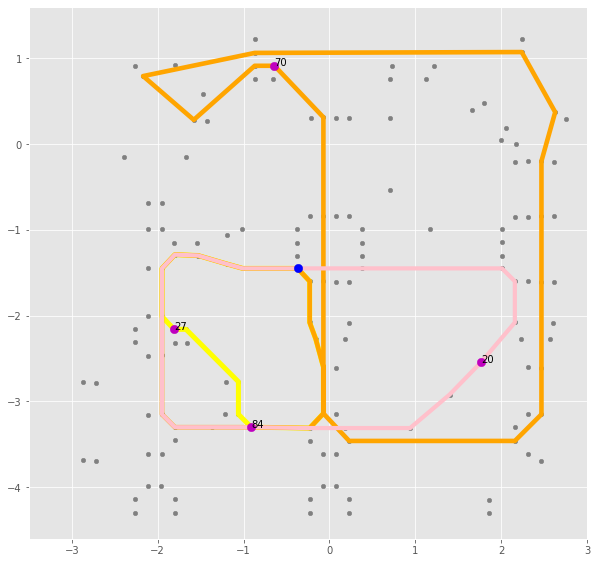

In [ ]:
# create and show widgets
num_packages = widgets.IntSlider(value=4, min=3,max=12,description="Number of Packages", style=style,layout=slider_layout)
num_vehicles = widgets.IntSlider(value=1, min=1, max=4, description="Number of Vehicles", style=style, layout=slider_layout)
btn = widgets.Button(description='Go')
display.display(num_packages,num_vehicles,btn)
full_costs = []

#set starting values for the demo, with 4 packages / 1 vehicle
paths, packages, full_costs = main(num_packages.value,num_vehicles.value)
print("Packages:",packages)
show_plot(paths,packages)

def update_vehicles_range(*args): #link packages to vehicles max
    num_vehicles.max =  num_packages.value
num_packages.observe(update_vehicles_range, 'value')

def handle_click(b):
  global paths, packages, full_costs
  display.clear_output()
  display.display(num_packages,num_vehicles,btn)
  paths, packages, full_costs = main(num_packages.value,num_vehicles.value)
  print("Packages:",packages)
  show_plot(paths,packages)

btn.on_click(handle_click)



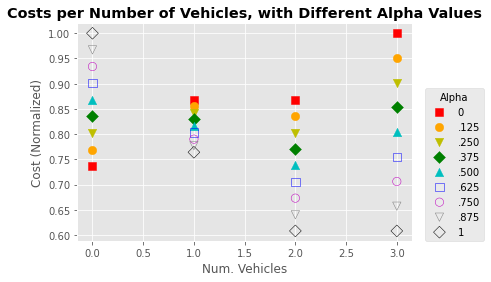

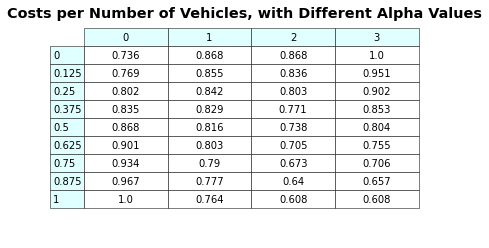

In [ ]:
# display costs with different alpha values for the package scenario shown above
scatter_plot_alphas(full_costs)
print()
table_alphas(full_costs)

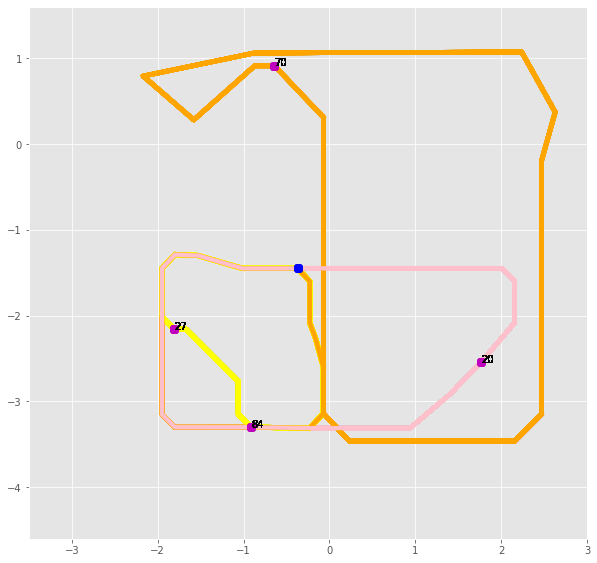

In [ ]:
#generate and display animation of paths shown above (takes ~10-30 seconds)
anim = animate_plot(paths, packages)
anim 